In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models.resnet import BasicBlock
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
%config InlineBackend.figure_format = 'retina'


print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.1+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## Model

In [3]:
# Define SceneClassifier
class SceneClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SceneClassifier, self).__init__()
        self.features = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
        # https://pytorch.org/vision/stable/models.html
        num_ftrs = self.features.fc.in_features
        self.features.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        return x

In [4]:
best_model_path = "best_model_50_v1_crop_320_train_all_three_sources.pth"  # Define where to save the best model

In [5]:
# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.CenterCrop(320),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomCrop(32, padding=4),  # randomly crop the image
    transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally
    transforms.RandomRotation(10),  # randomly rotate the image
    transforms.RandomVerticalFlip(),  # randomly flip the image vertically
])

## Load the data

In [6]:
# Load the dataset
train_dataset = ImageFolder("data/final_model/train", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
model = SceneClassifier(num_classes=len(train_dataset.classes)).to(device)

In [8]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Visualize data

Here we investigate what a batch of our training data looks like.

Notice that our `images` tensor contains the normalized image data, and has shape NxCxHxW, and the `targets` tensor is essentially a list of corresponding target class labels with shape N (batch_size).

images: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([32, 3, 224, 224])
targets: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


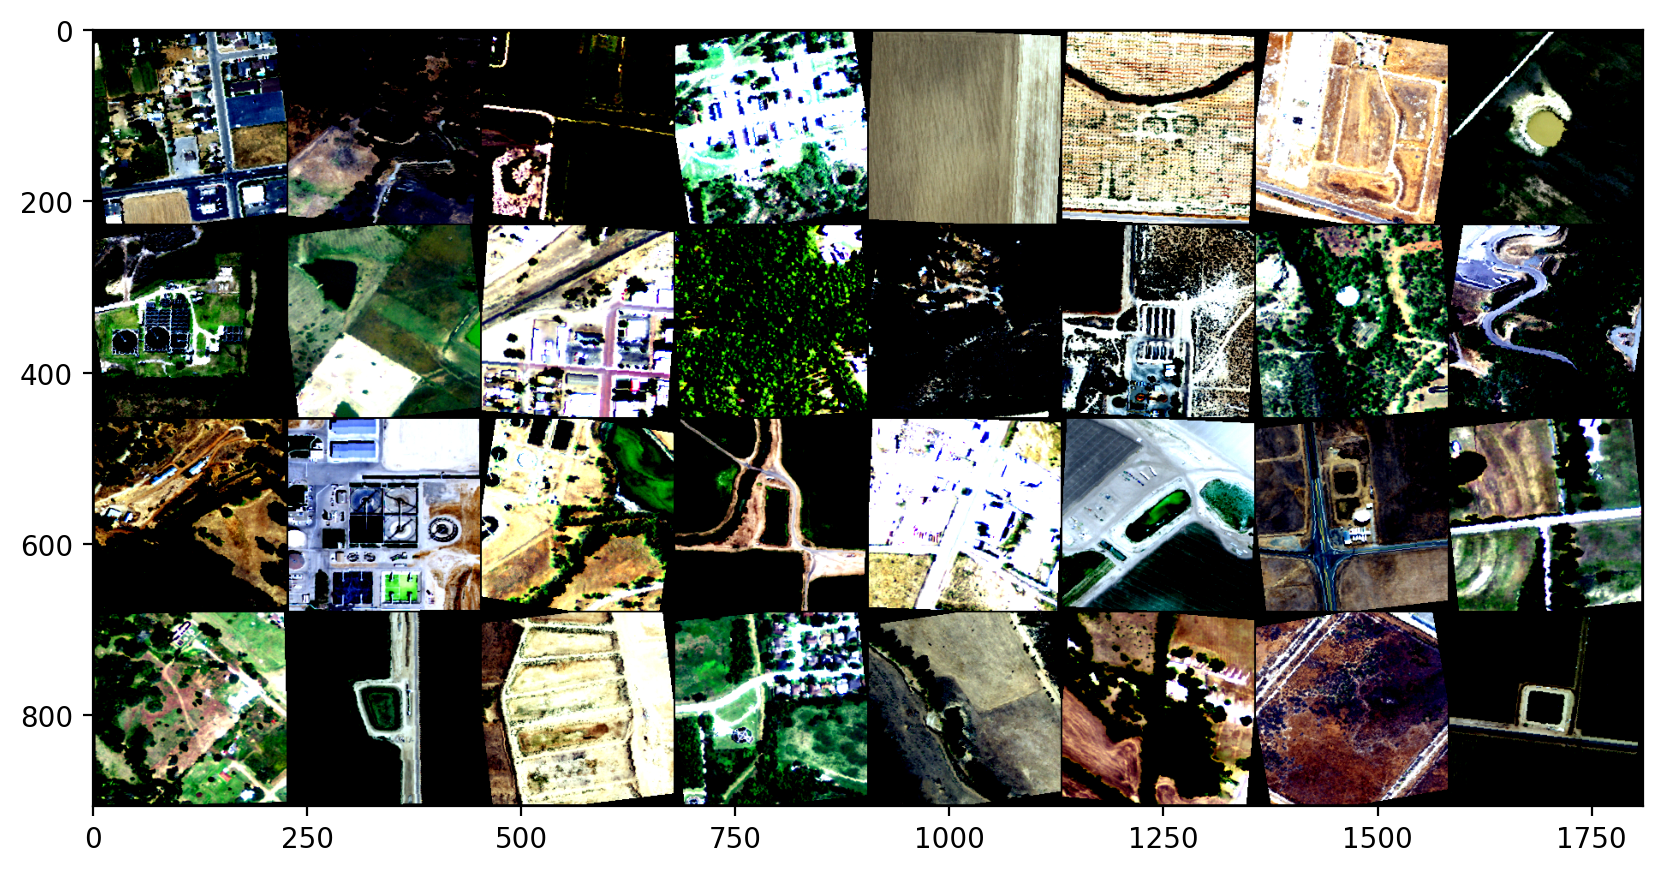

In [9]:
# Grab a batch of training data
images, targets = next(iter(train_loader))
# Print data tensors
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [10]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4920
    Root location: data/final_model/train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(320, 320))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.5)
           )

In [11]:
# Get the list of classes (subdirectories)
path = "./data/final_model/train"
classes = os.listdir(path)

# Get the list of classes (subdirectories)
classes = [class_name for class_name in os.listdir(path)
           if os.path.isdir(os.path.join(path, class_name))]

# Create a dictionary to store the counts
class_counts = {}

# Iterate over each class directory and count the number of files
for class_name in classes:
    class_path = os.path.join(path, class_name)
    file_count = len(os.listdir(class_path))
    class_counts[class_name] = file_count

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Files: {count}")


Class: No, Number of Files: 3870
Class: Yes, Number of Files: 1050


In [12]:
for class_idx, class_name in enumerate(classes):
    print(f"Class Index: {class_idx}, Class Name: {class_name}")

Class Index: 0, Class Name: No
Class Index: 1, Class Name: Yes


## Train the model


Epoch [1/17]


Training loss: 0.4038, Training accuracy: 75.0203
Precision: 0.6722, Recall: 0.7264, F1 Score: 0.6839
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


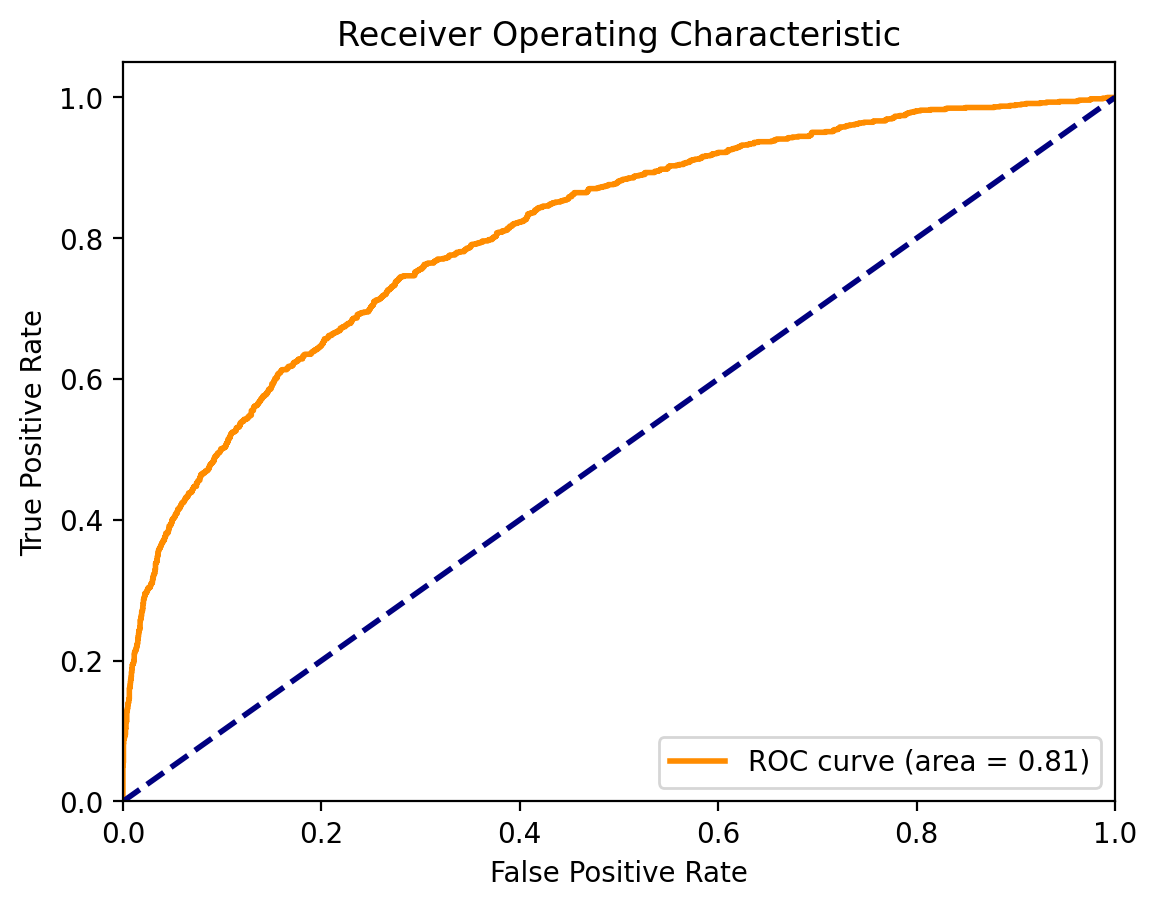


Epoch [2/17]


Training loss: 0.3340, Training accuracy: 80.3659
Precision: 0.7257, Recall: 0.7836, F1 Score: 0.7435
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


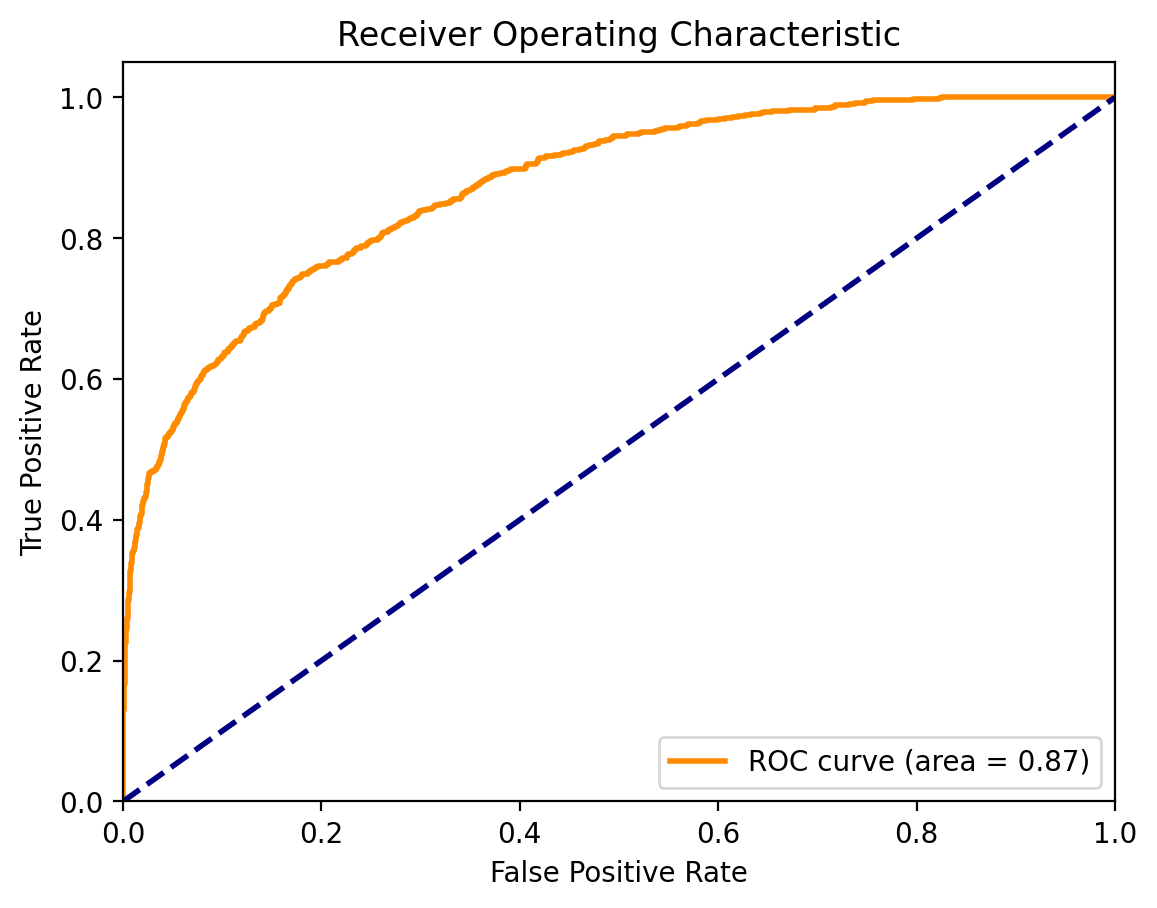


Epoch [3/17]


Training loss: 0.2948, Training accuracy: 82.5610
Precision: 0.7498, Recall: 0.8083, F1 Score: 0.7695
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


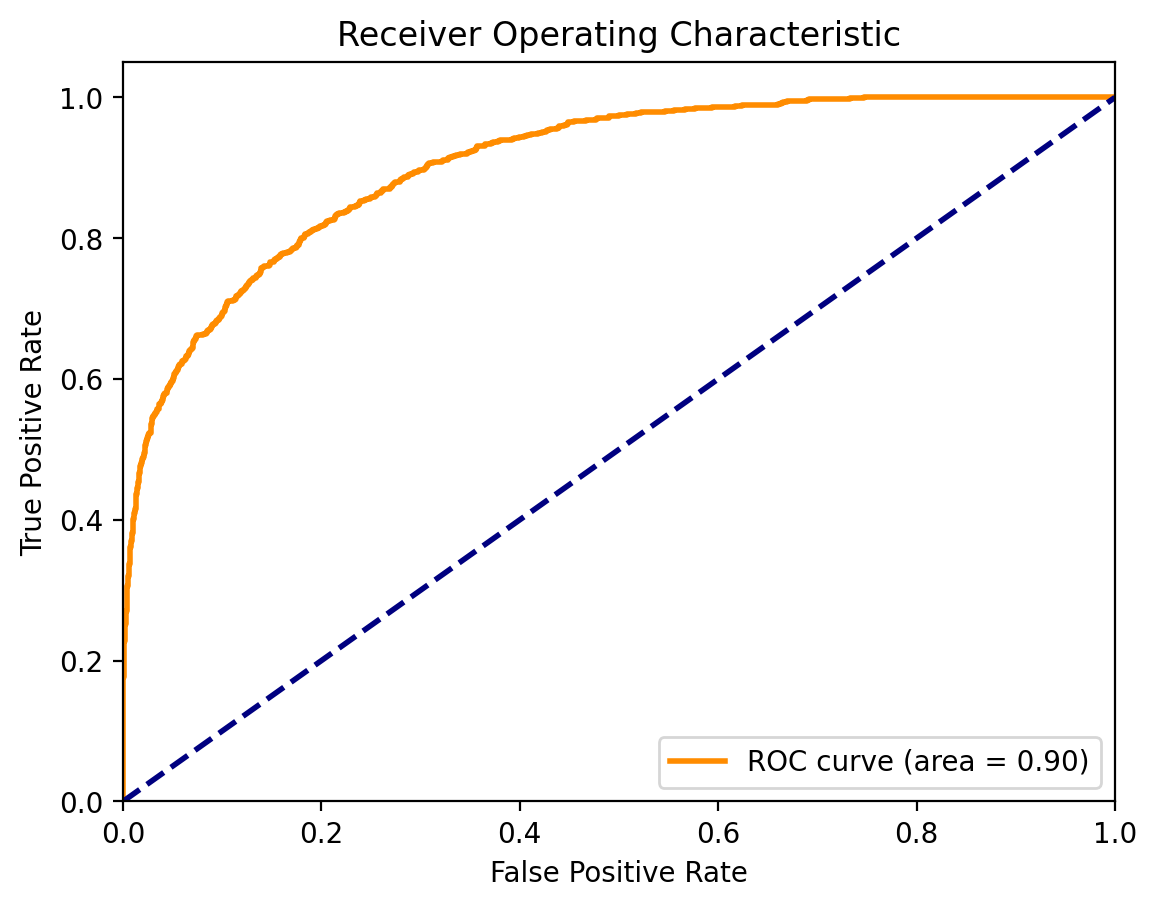


Epoch [4/17]


Training loss: 0.2736, Training accuracy: 84.2276
Precision: 0.7691, Recall: 0.8286, F1 Score: 0.7900
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


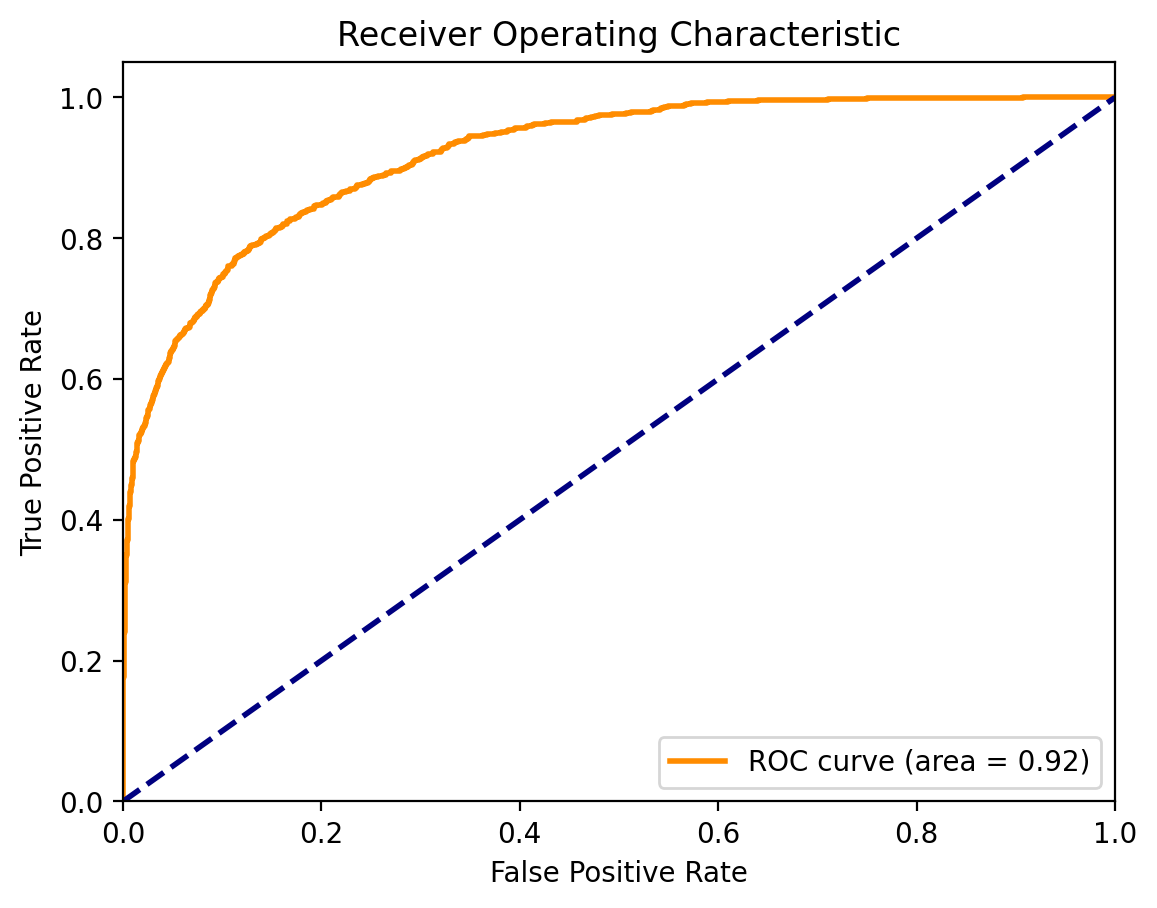


Epoch [5/17]


Training loss: 0.2464, Training accuracy: 85.5285
Precision: 0.7849, Recall: 0.8476, F1 Score: 0.8073
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


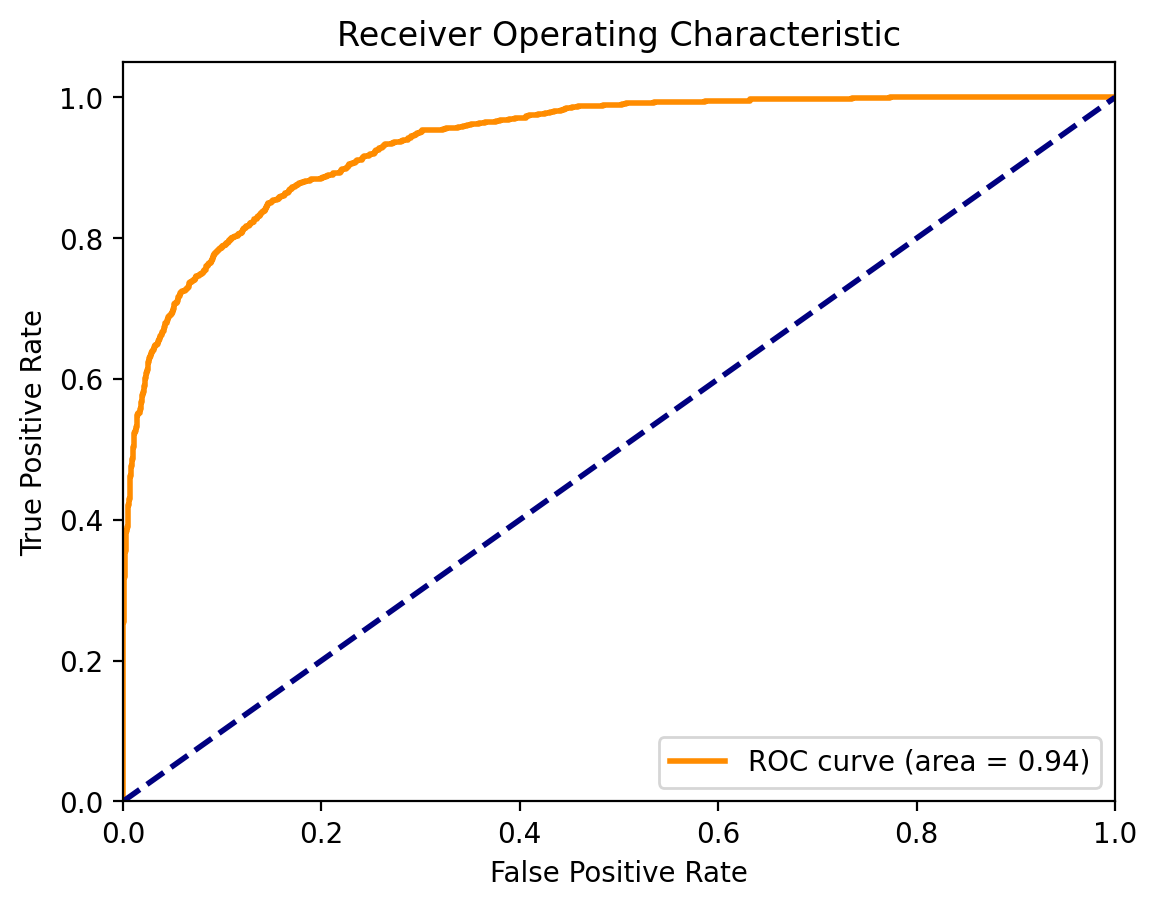


Epoch [6/17]


Training loss: 0.2267, Training accuracy: 87.2764
Precision: 0.8058, Recall: 0.8653, F1 Score: 0.8283
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


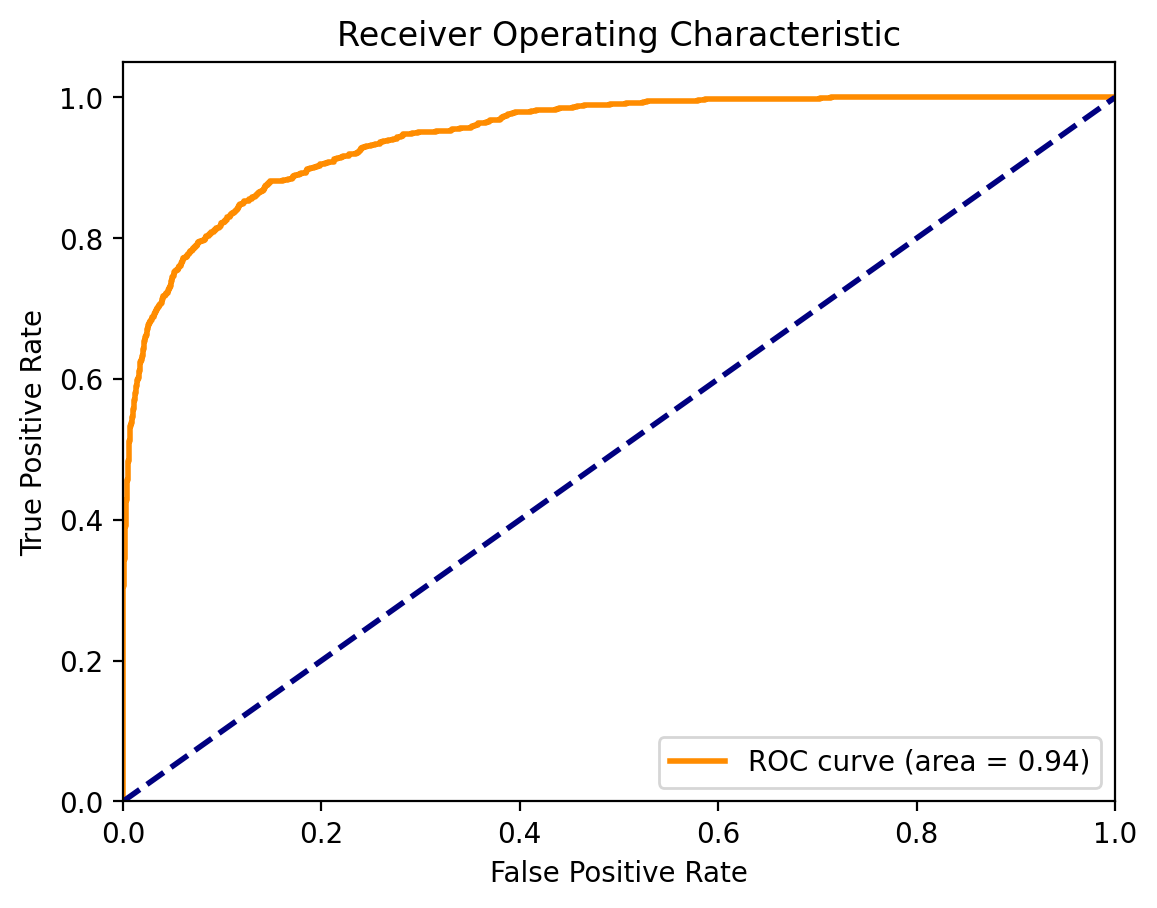


Epoch [7/17]


Training loss: 0.2072, Training accuracy: 88.2927
Precision: 0.8185, Recall: 0.8805, F1 Score: 0.8420
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


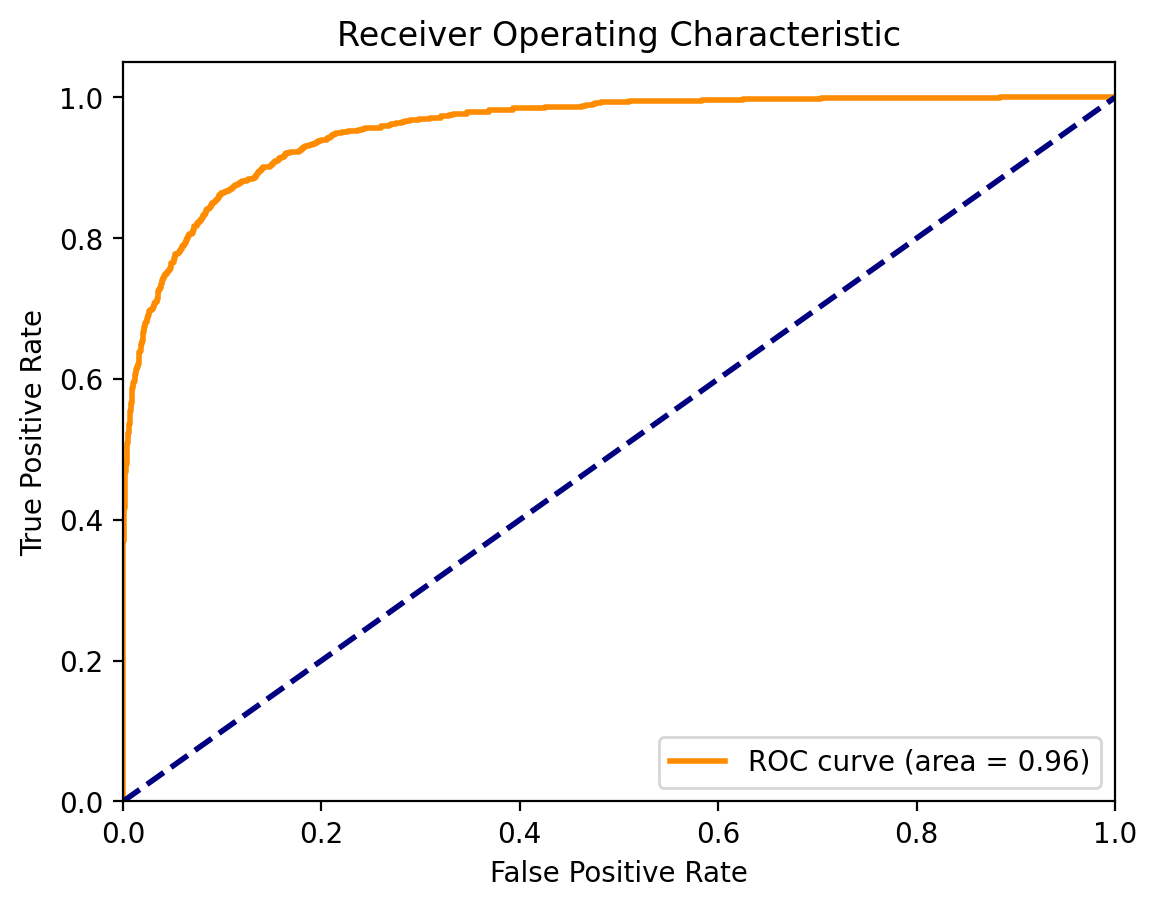


Epoch [8/17]


Training loss: 0.1831, Training accuracy: 90.0610
Precision: 0.8408, Recall: 0.9018, F1 Score: 0.8648
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


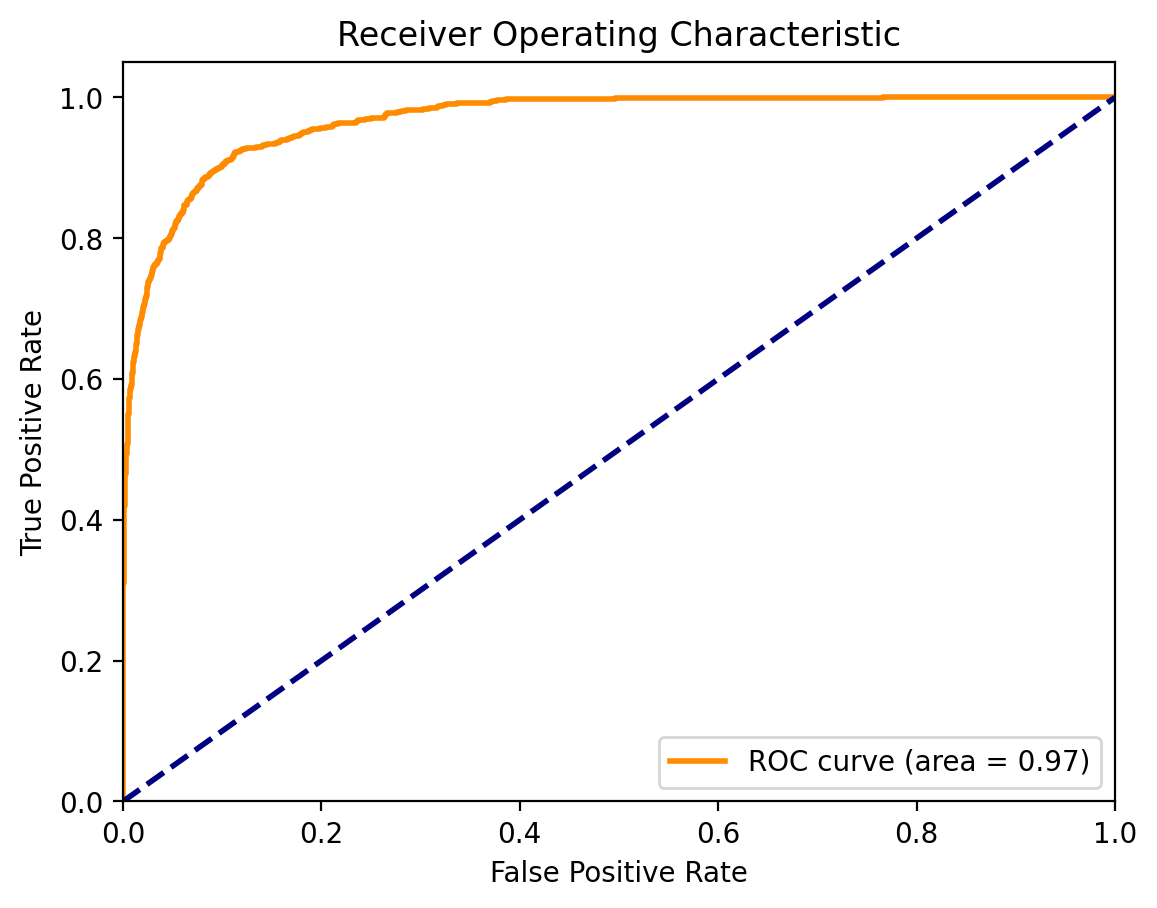


Epoch [9/17]


Training loss: 0.1637, Training accuracy: 90.8333
Precision: 0.8507, Recall: 0.9115, F1 Score: 0.8749
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


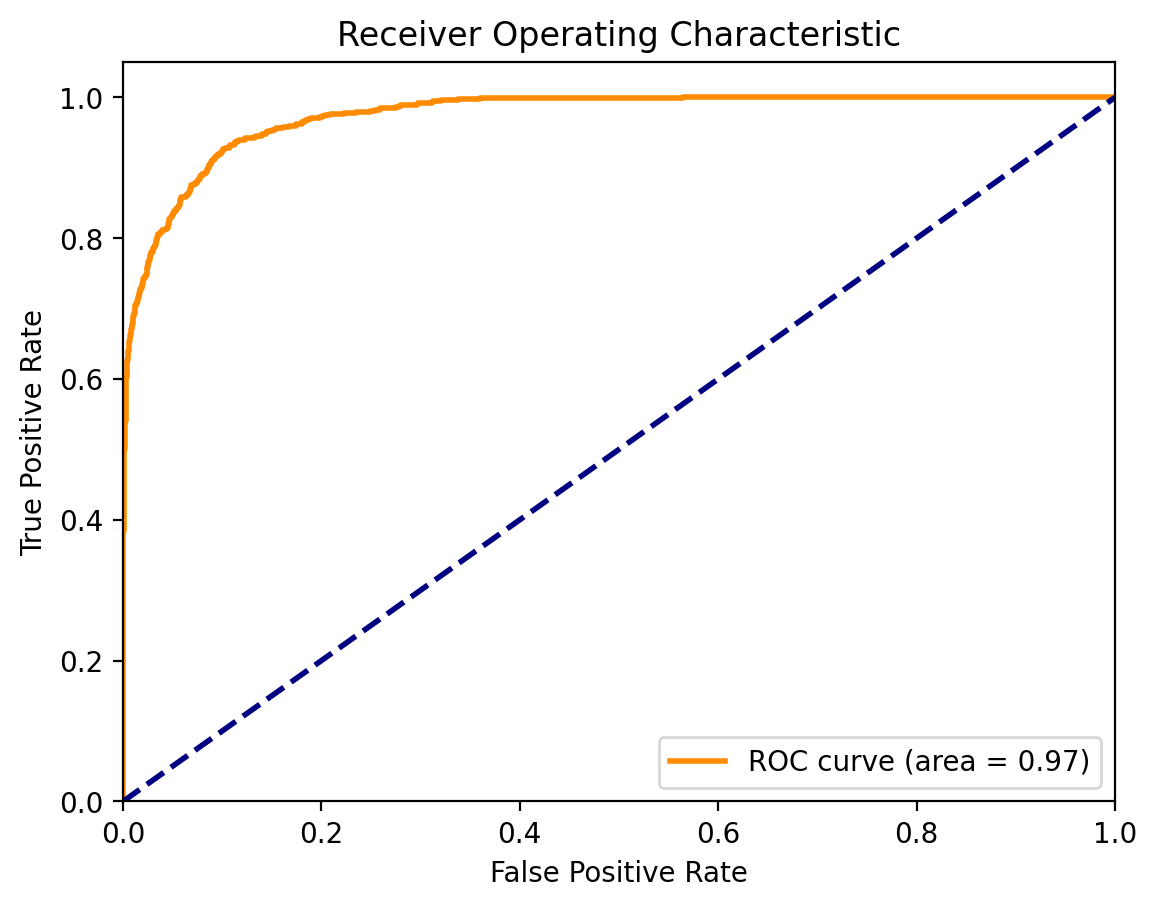


Epoch [10/17]


Training loss: 0.1448, Training accuracy: 92.1138
Precision: 0.8681, Recall: 0.9242, F1 Score: 0.8912
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


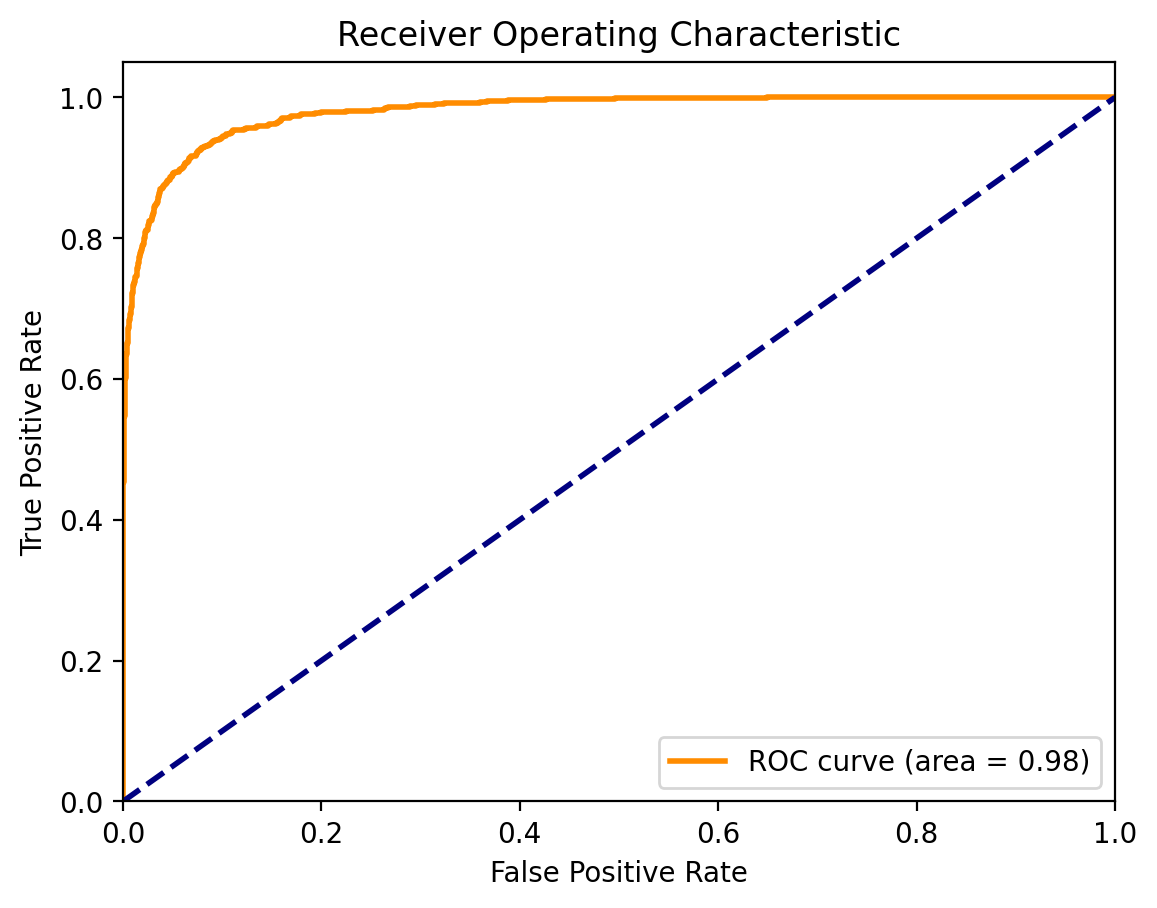


Epoch [11/17]


Training loss: 0.1418, Training accuracy: 92.6829
Precision: 0.8773, Recall: 0.9250, F1 Score: 0.8977
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


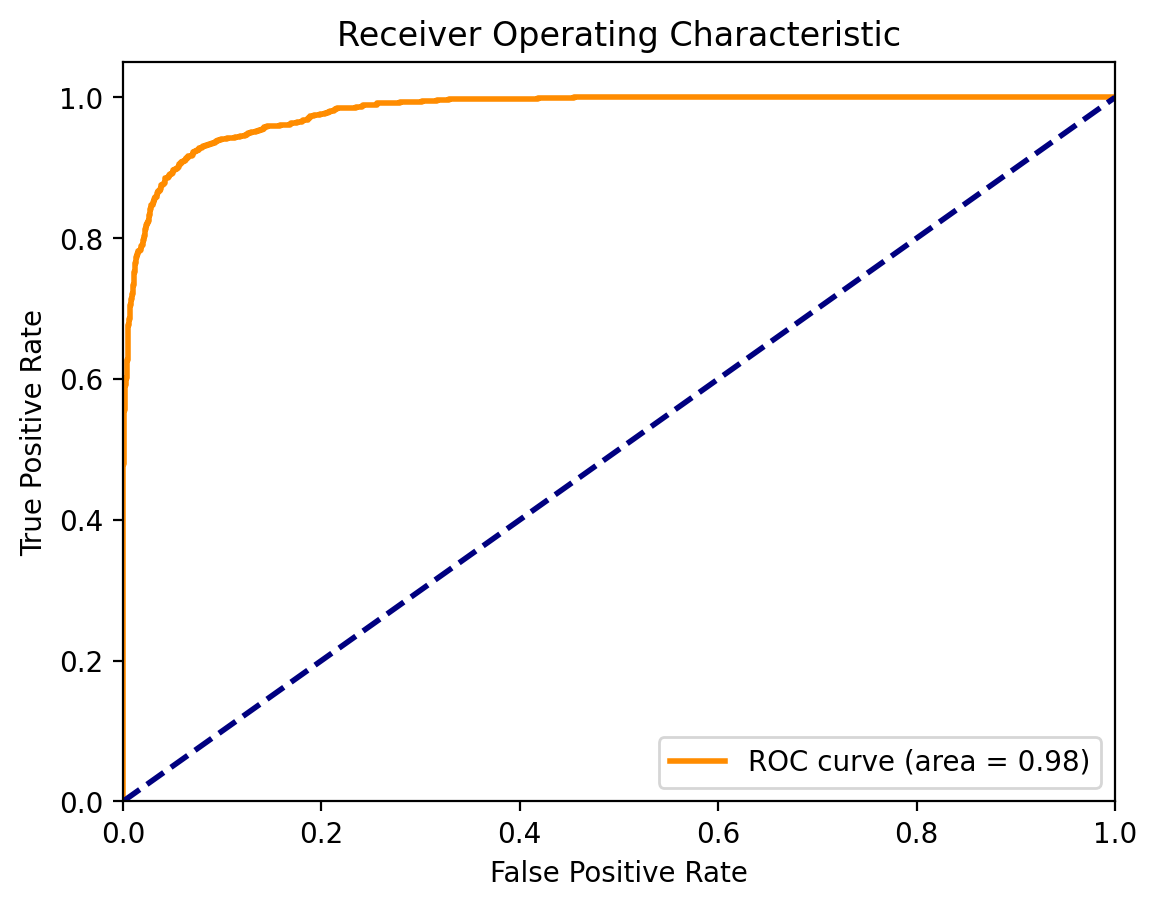


Epoch [12/17]


Training loss: 0.1232, Training accuracy: 93.8008
Precision: 0.8922, Recall: 0.9412, F1 Score: 0.9133
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


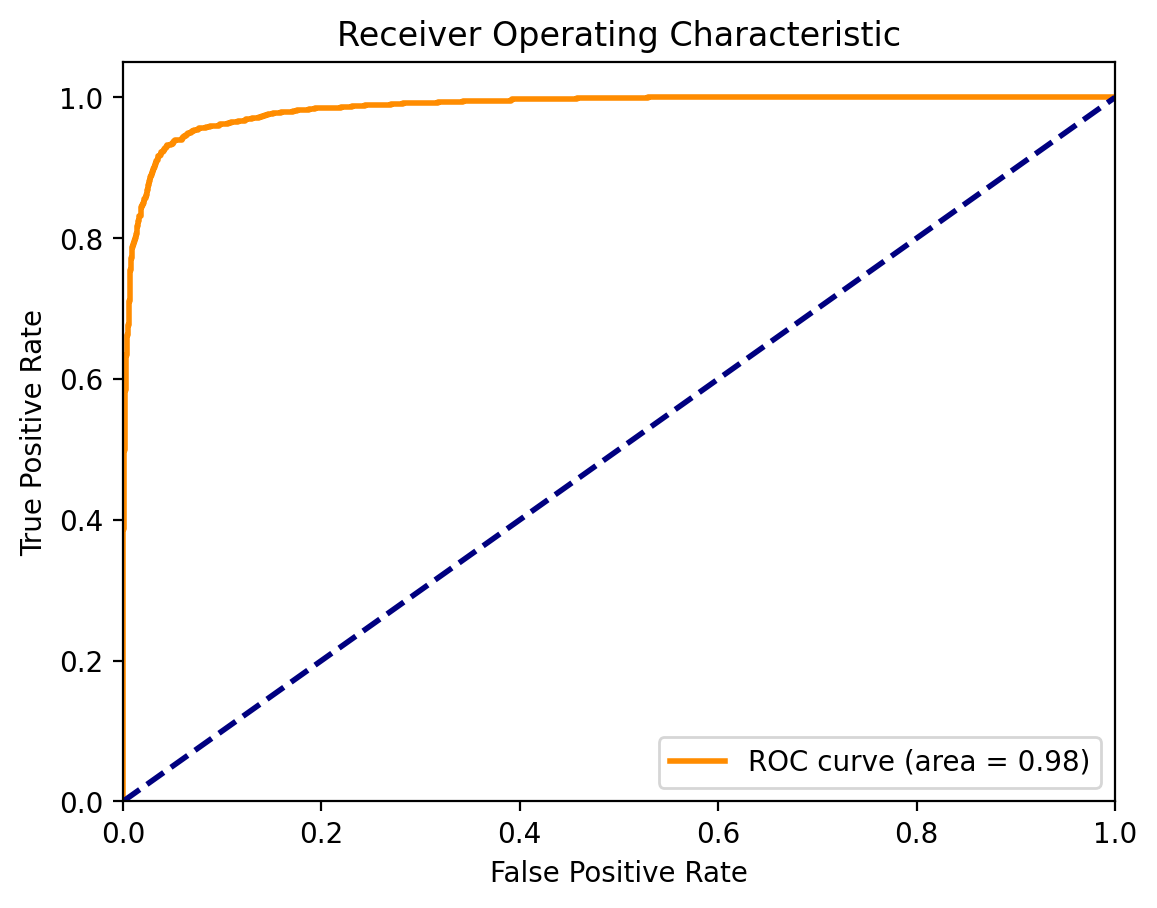


Epoch [13/17]


Training loss: 0.1143, Training accuracy: 94.3699
Precision: 0.9007, Recall: 0.9469, F1 Score: 0.9209
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


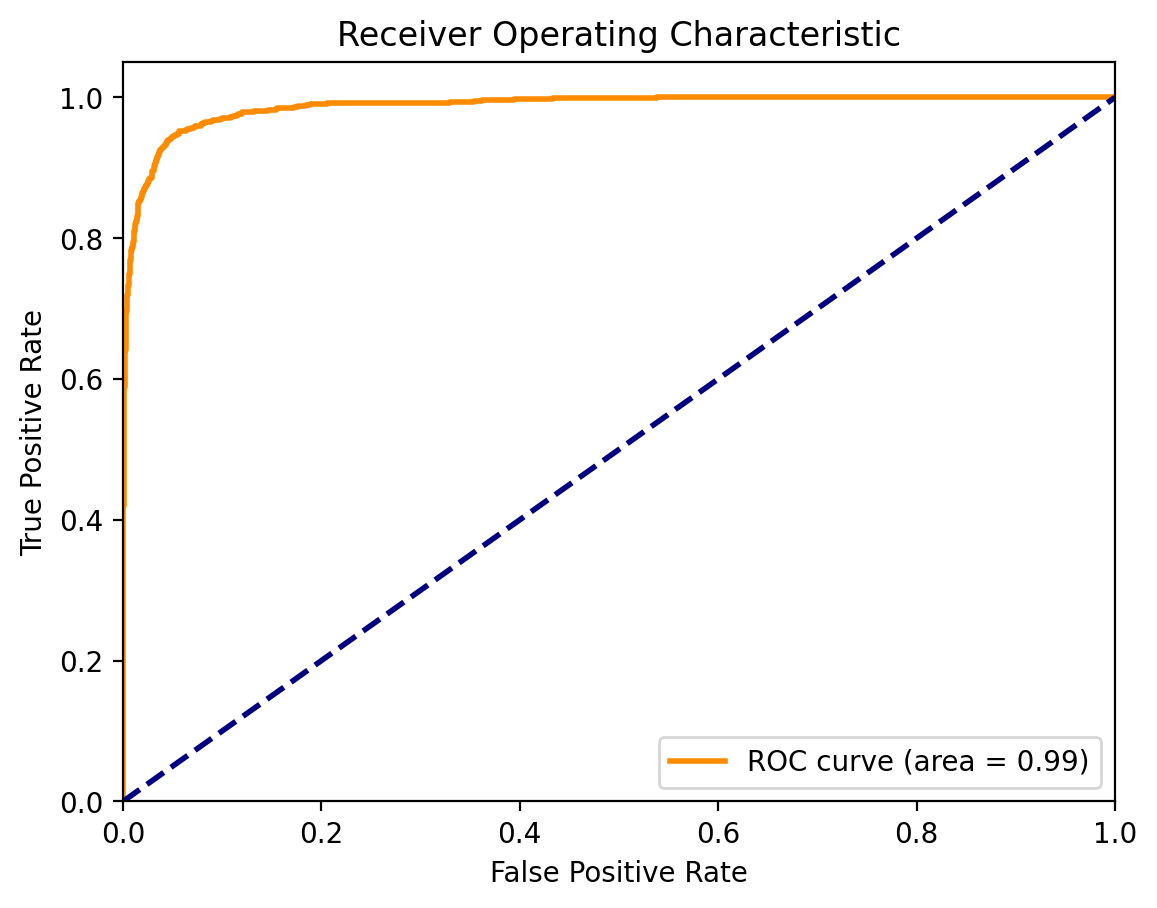


Epoch [14/17]


Training loss: 0.1011, Training accuracy: 94.7967
Precision: 0.9077, Recall: 0.9499, F1 Score: 0.9264
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


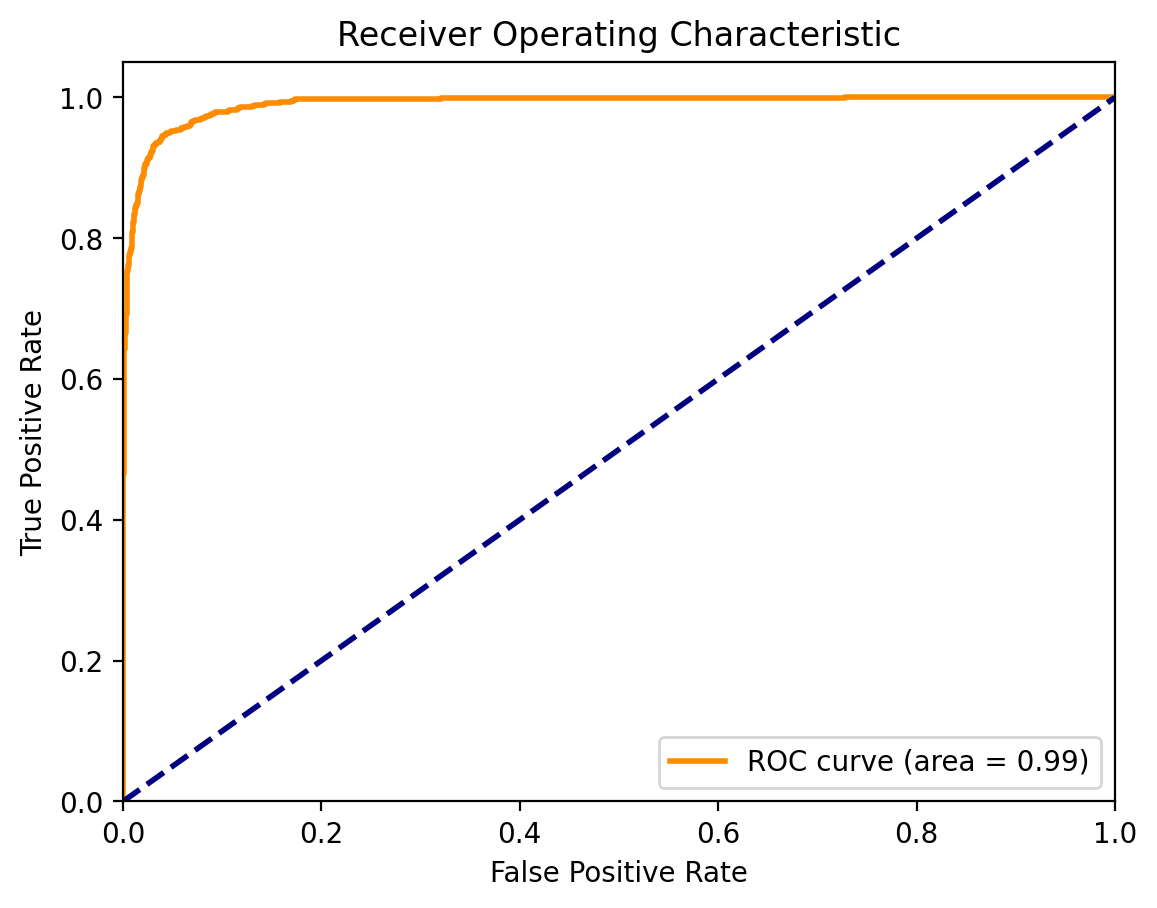


Epoch [15/17]


Training loss: 0.0847, Training accuracy: 95.9756
Precision: 0.9265, Recall: 0.9616, F1 Score: 0.9425
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


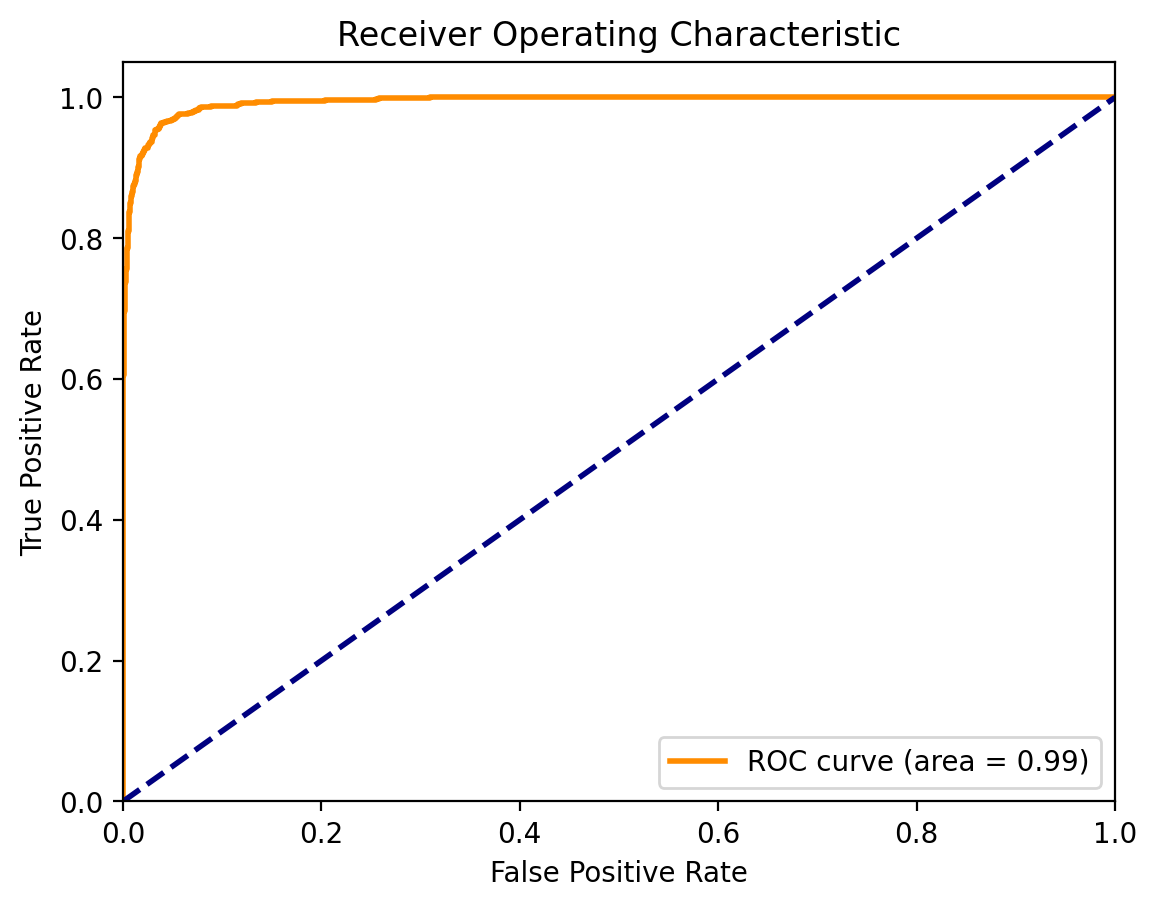


Epoch [16/17]


Training loss: 0.0777, Training accuracy: 95.9553
Precision: 0.9272, Recall: 0.9594, F1 Score: 0.9420

Epoch [17/17]


Training loss: 0.0764, Training accuracy: 96.1992
Precision: 0.9310, Recall: 0.9623, F1 Score: 0.9454
Best model saved at: best_model_50_v1_crop_320_train_all_three_sources.pth


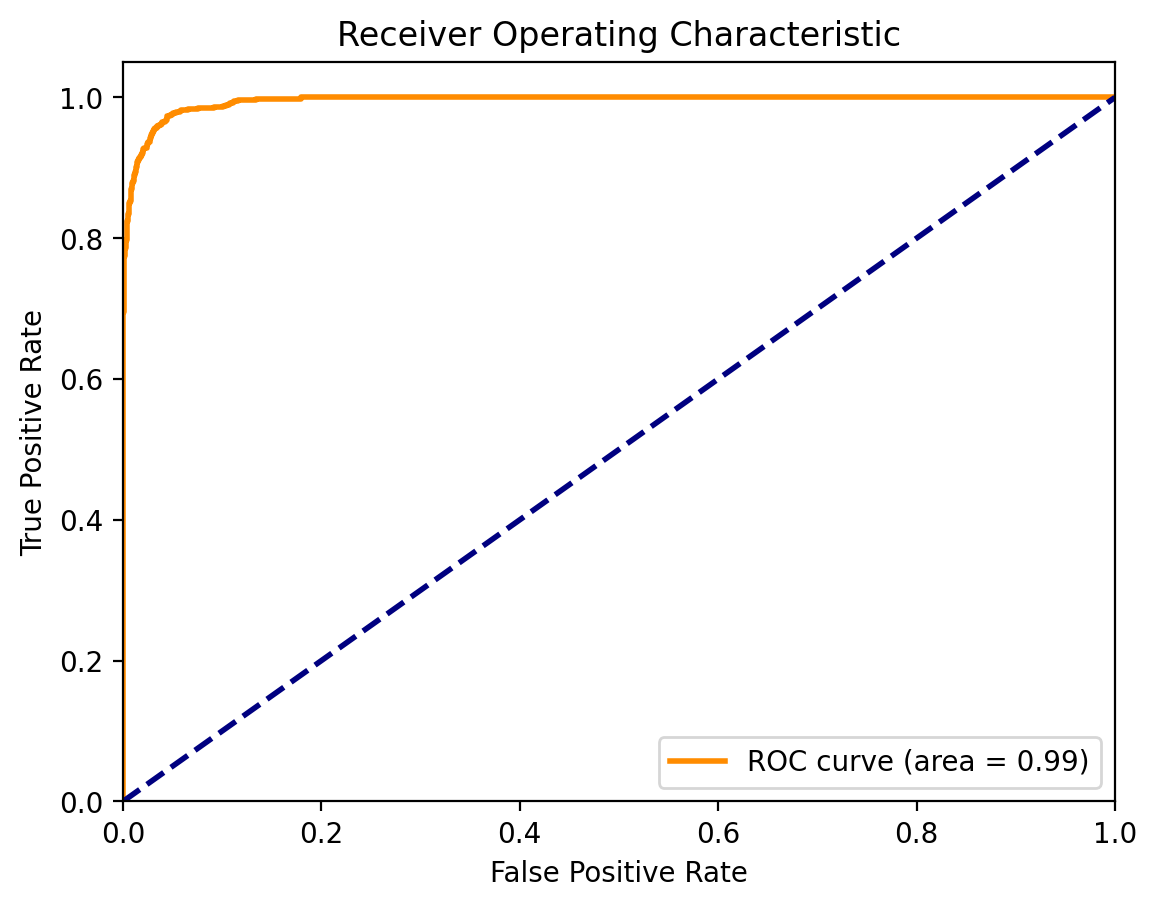

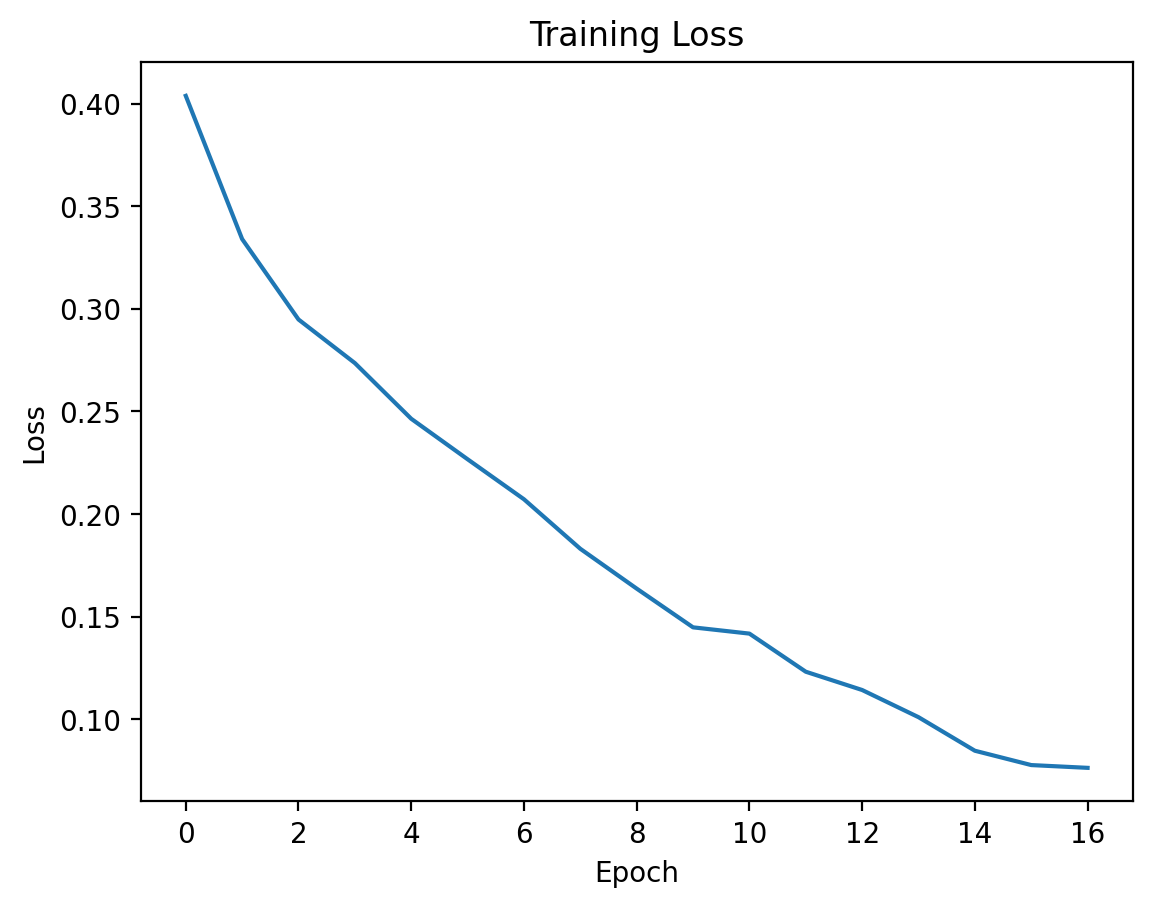

In [13]:
best_recall = 0.0

epochs = 17
loss_list = []


for i in range(1, epochs + 1):
    # Put model in train mode
    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    all_targets = []
    all_predicted = []
    all_probs = []

    # Wrap train_loader with tqdm for the progress bar
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {i}/{epochs}', leave=False)

    # Train the training dataset for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader_iter):
        # Copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass images through model
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predictions
        probs = nn.functional.softmax(outputs, dim=1)
        CUSTOM_THRESHOLD = 0.2236
        predicted = (probs[:, 1] > CUSTOM_THRESHOLD).long()
        # Append to totals
        total_ims += targets.shape[0]
        total_batches += 1
        total_loss += loss.item()
        total_corrects += predicted.eq(targets).sum().item()
        # Append targets, predicted, and probabilities for ROC curve calculation
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = total_loss / total_batches
    loss_list.append(avg_loss)
    acc = (total_corrects / total_ims) * 100.0
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_targets, all_predicted, average='macro')
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))

    # Check if current recall is better than the previous best recall
    if recall > best_recall:
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at:", best_model_path)
        # Update the best recall value
        best_recall = recall

        # only plot roc curve for current best model
        # Extract probabilities of the positive class
        positive_probs = [prob[1] for prob in all_probs]
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(all_targets, positive_probs, pos_label=1)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

# plot the loss
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
